In [156]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#import pymc_bart as pmb
import warnings
from pathlib import Path
import glob
import pandas as pd
import polars as pl
import numpy as np
from torch.utils.data import DataLoader
import sys
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error,f1_score,
                             accuracy_score, roc_auc_score, confusion_matrix)

# Importing of the data

In [157]:
DATA_DIR = Path("../nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder and load test file
input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))
test = sorted(glob.glob(str(DATA_DIR /'test.csv')))

print(f'Input files: {len(input_files)}')
print(f'Output files: {len(output_files)}')

Input files: 18
Output files: 18


In [158]:
input_df = pd.concat([pd.read_csv(f) for f in input_files], ignore_index=True)
output_df = pd.concat([pd.read_csv(f) for f in output_files], ignore_index=True)
test_data = pd.read_csv(str(DATA_DIR /'test.csv'))
print("------------ INPUT DF INFO ------------ ")
input_df.info(show_counts=True)

print(" ------------ OUTPUT DF INFO ------------  ")
output_df.info(show_counts=True)

 ######## INPUT DF INFO ######## 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   4880579 non-null  int64  
 1   play_id                   4880579 non-null  int64  
 2   player_to_predict         4880579 non-null  bool   
 3   nfl_id                    4880579 non-null  int64  
 4   frame_id                  4880579 non-null  int64  
 5   play_direction            4880579 non-null  object 
 6   absolute_yardline_number  4880579 non-null  int64  
 7   player_name               4880579 non-null  object 
 8   player_height             4880579 non-null  object 
 9   player_weight             4880579 non-null  int64  
 10  player_birth_date         4880579 non-null  object 
 11  player_position           4880579 non-null  object 
 12  player_side               4880579 non-null  object

## Creating functions for feature engineering

In [159]:
def create_advanced_features(df):
    """Create comprehensive feature set for optimal prediction"""
    df = df.copy()

    # Ball-related features
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 +
        (df['y'] - df['ball_land_y'])**2
    )

    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )

    df['angle_to_ball_deg'] = np.degrees(df['angle_to_ball'])

    df['speed_to_ball'] = df['s'] * np.cos(
        np.radians(df['dir']) - df['angle_to_ball']
    )

    df['delta_x_to_ball'] = df['ball_land_x'] - df['x']
    df['delta_y_to_ball'] = df['ball_land_y'] - df['y']
    df['manhattan_dist_to_ball'] = np.abs(df['delta_x_to_ball']) + np.abs(df['delta_y_to_ball'])
    df['eucl_dist_to_ball'] = np.sqrt((df['ball_land_x'] - df['x'])**2 + (df['ball_land_y'] - df['y'])**2)
    df['x_y_dist_ratio'] = np.abs(df['delta_x_to_ball']) / (np.abs(df['delta_y_to_ball']) + 0.1)

    # Role encoding
    role_map = {
        'Targeted Receiver': 4,
        'Defensive Coverage': 3,
        'Other Route Runner': 2,
        'Passer': 1
    }
    df['role_encoded'] = df['player_role'].map(role_map).fillna(0)

    df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
    df['is_targeted'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['is_defender'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(int)

    # Field position
    df['field_position'] = df['absolute_yardline_number']
    df['play_dir_encoded'] = (df['play_direction'] == 'right').astype(int)

    df['dist_from_left_sideline'] = df['y']
    df['dist_from_right_sideline'] = 53.3 - df['y']
    df['dist_from_nearest_sideline'] = np.minimum(
        df['dist_from_left_sideline'],
        df['dist_from_right_sideline']
    )
    df['dist_from_endzone'] = np.minimum(df['x'], 120 - df['x'])

    # Velocity and acceleration components
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    df['ax'] = df['a'] * np.cos(np.radians(df['dir']))
    df['ay'] = df['a'] * np.sin(np.radians(df['dir']))
    df['speed_squared'] = df['s'] ** 2
    df['accel_squared'] = df['a'] ** 2

    # Orientation features
    df['orientation_dir_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_dir_diff'] = np.where(
        df['orientation_dir_diff'] > 180,
        360 - df['orientation_dir_diff'],
        df['orientation_dir_diff']
    )
    df['facing_ball'] = (df['orientation_dir_diff'] < 90).astype(int)

    # Physics-based features
    df['expected_time_to_ball'] = df['dist_to_ball_land'] / (df['s'] + 0.1)
    df['frames_after_ball'] = df['num_frames_output'] - (df['expected_time_to_ball'] * 10)

    df['estimated_x_next'] = df['x'] + df['vx'] * 0.1
    df['estimated_y_next'] = df['y'] + df['vy'] * 0.1
    df['estimated_x_1sec'] = df['x'] + df['vx']
    df['estimated_y_1sec'] = df['y'] + df['vy']

    df['can_reach_ball'] = (df['expected_time_to_ball'] < df['num_frames_output'] * 0.1).astype(int)

    # Kinetic energy proxy
    df['kinetic_energy'] = 0.5 * df['speed_squared']

    # Trajectory curvature proxy
    df['velocity_angle'] = np.arctan2(df['vy'], df['vx'])
    df['trajectory_alignment'] = np.abs(df['velocity_angle'] - df['angle_to_ball'])

    return df

In [160]:
def add_sequence_features(df, window=3):
    """Add temporal sequence features"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    # Velocity changes
    df['delta_vx'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vx'].diff()
    df['delta_vy'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vy'].diff()
    df['delta_speed'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].diff()

    # Acceleration changes (jerk)
    df['delta_ax'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ax'].diff()
    df['delta_ay'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ay'].diff()

    # Rolling statistics
    for col in ['s', 'a', 'vx', 'vy']:
        df[f'{col}_rolling_mean'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{col}_rolling_std'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    df.fillna(0, inplace=True)

    return df

In [161]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = create_advanced_features(df)
    df = add_sequence_features(df)
    return df

engineered_df = engineer_features(input_df)

In [162]:
non_numeric = [c for c in engineered_df.columns if engineered_df[c].dtype == 'object']

In [170]:
players2predict = engineered_df[engineered_df["player_to_predict"] == True].copy()

merged = players2predict.merge(
    output_df,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    suffixes=("_input", "_output")
)

def height_to_inches(h):
    try:
        f, i = h.split("-")
        return int(f) * 12 + int(i)
    except:
        return np.nan

merged["player_height"] = merged["player_height"].apply(height_to_inches)
merged["play_direction_encoded"] = (merged["play_direction"] == "right").astype(int)

merged = pd.concat([
    merged,
    pd.get_dummies(merged["player_position"], prefix="position"),
    pd.get_dummies(merged["player_role"], prefix="role")
], axis=1)

feature_cols = ['absolute_yardline_number', 'player_weight', 'x_input', 'y_input', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
       'dist_to_ball_land', 'angle_to_ball', 'angle_to_ball_deg',
       'speed_to_ball', 'delta_x_to_ball', 'delta_y_to_ball',
       'manhattan_dist_to_ball', 'x_y_dist_ratio',
       'is_offense', 'is_targeted', 'is_defender', 'is_passer',
       'field_position', 'play_dir_encoded', 'dist_from_left_sideline',
       'dist_from_right_sideline', 'dist_from_nearest_sideline',
       'dist_from_endzone', 'vx', 'vy', 'ax', 'ay', 'speed_squared',
       'accel_squared', 'orientation_dir_diff', 'facing_ball',
       'expected_time_to_ball', 'frames_after_ball', 'estimated_x_next',
       'estimated_y_next', 'estimated_x_1sec', 'estimated_y_1sec',
       'can_reach_ball', 'kinetic_energy', 'velocity_angle',
       'trajectory_alignment', 'delta_vx', 'delta_vy', 'delta_speed',
       'delta_ax', 'delta_ay', 's_rolling_mean', 's_rolling_std',
       'a_rolling_mean', 'a_rolling_std', 'vx_rolling_mean', 'vx_rolling_std',
       'vy_rolling_mean', 'vy_rolling_std']+ [c for c in merged.columns if c.startswith(("position_", "role_"))]

X = merged[feature_cols].fillna(0)
y = merged[["x_output","y_output"]]


In [171]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55
)

In [172]:
model = CatBoostRegressor(iterations=5,
                           depth=3,
                           learning_rate=0.002,
                           loss_function='RMSE',
                           verbose=True)
# train the model
try:
    model.fit(X_train, y_train)
except Exception as e:
    print(f"Error: {e}") # throw Exception so the execution does not halt here

Error: catboost/private/libs/target/data_providers.cpp:639: Currently only multi-regression, multilabel and survival objectives work with multidimensional target


In [166]:
decision_tree = DecisionTreeRegressor(max_depth=20)
decision_tree.fit(X_train, y_train)
dt_preds = decision_tree.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
print(dt_rmse)

1.9937112781901294


In [167]:
import time
base_tree = DecisionTreeRegressor(max_depth=15)

# Define bagging ensemble
bagged_model = BaggingRegressor(
    estimator=base_tree,
    n_estimators=100,       # number of trees
    max_samples=0.7,        # fraction of training data per tree
    max_features=1.0,       # fraction of features per tree
    bootstrap=True,         # with replacement
    n_jobs=-4,              # parallelize
    random_state=55
)
start = time.time()
bagged_model.fit(X_train, y_train)
end = time.time()
print(f'Bagged model fitted after {end-start} , starting predictions.....')
bagged_model_preds = bagged_model.predict(X_test)
print(f'Predictions completed')

bagged_rmse = np.sqrt(mean_squared_error(y_test, bagged_model_preds))
print(bagged_rmse)

Python(88000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Bagged model fitted, starting predictions.....
Predictions completed


In [168]:
# x_true = X_train["x_input"]
# y_true = X_train["y_input"]
# x_pred = y_test['x']
# y_pred = y_test['y']

In [169]:
y_train_x = y_train.iloc[:, 0].values   # or y_train[:, 0] if it's ndarray
y_train_y = y_train.iloc[:, 1].values

model_x = HistGradientBoostingRegressor(
                    loss='squared_error',
                    learning_rate=0.01, max_iter=200, max_leaf_nodes=31, max_depth=20,
                    min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255,
                    categorical_features='from_dtype', monotonic_cst=None, interaction_cst=None,
                    warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=55
                        )
model_y = HistGradientBoostingRegressor(
                    loss='squared_error',
                    learning_rate=0.01, max_iter=200, max_leaf_nodes=31, max_depth=20,
                    min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255,
                    categorical_features='from_dtype', monotonic_cst=None, interaction_cst=None,
                    warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=55
                        )

model_x.fit(X_train.values, y_train_x)
model_y.fit(X_train.values, y_train_y)

InvalidParameterError: The 'max_bins' parameter of HistGradientBoostingRegressor must be an int in the range [2, 255]. Got 350 instead.

In [100]:
pred_x = model_x.predict(X_test)
pred_y = model_y.predict(X_test)

hist_gboost_preds = np.column_stack([pred_x, pred_y])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [98]:
hist_gradboost = HistGradientBoostingRegressor(
    loss='squared_error', learning_rate=0.01, max_iter=200,
    max_leaf_nodes=31, max_depth=20, validation_fraction=0.1,
    n_iter_no_change=10, tol=1e-07, verbose=0
)

multi_model = MultiOutputRegressor(hist_gradboost)
multi_model.fit(X_train.values, y_train.values)  # y_train must be (n,2)


MultiOutputRegressor(estimator=HistGradientBoostingRegressor(learning_rate=0.01,
                                                             max_depth=20,
                                                             max_iter=200))

In [152]:
# YET TO RUN, was taking too much time -> find more optimal way to run
# with pm.Model() as model_coal:
#     μ_ = pmb.BART("μ_", X=X_train, Y=np.log(y_train), m=20)
#     μ = pm.Deterministic("μ", pm.math.exp(μ_))
#     y_pred = pm.Poisson("y_pred", mu=μ, observed=y_train)
#     idata_coal = pm.sample(random_seed=55)

NameError: name 'pm' is not defined

In [ ]:
bart_model = MultiOutputRegressor(pmb.BART(n_trees=50, n_jobs=-1, verbose=True))
bart_model.fit(X_train.values, y_train.values)
bart_preds = bart_model.predict(X_test.values)

rmse_bart = np.sqrt(mean_squared_error(y_test, bart_preds))
print(f"BART RMSE: {rmse_bart:.4f}")

In [ ]:
rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42
)

rf_model = MultiOutputRegressor(rf_base)
rf_model.fit(X_train.values, y_train.values)
rf_preds = rf_model.predict(X_test.values)

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
print(f"Random Forest RMSE: {rmse_rf:.4f}")

In [174]:
svr_rbf = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10, epsilon=0.1)
)

svr_model = MultiOutputRegressor(svr_rbf, n_jobs=-5)
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, svr_preds))
print(f"SVR RMSE: {rmse_svr:.4f}")

Python(88456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

In [ ]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# --- define base LightGBM regressor ---
lgb_reg = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.02,
    max_depth=-1,         # -1 = no limit
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)

multi_lgb = MultiOutputRegressor(lgb_reg)

# --- train ---
multi_lgb.fit(X_train.values, y_train.values)

# --- predict ---
pred_lgb = multi_lgb.predict(X_test.values)

# --- evaluate ---
rmse_x = np.sqrt(mean_squared_error(y_test.values[:, 0], y_pred_lgb[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_test.values[:, 1], y_pred_lgb[:, 1]))

print(f"LightGBM RMSE_x={rmse_x:.4f}, RMSE_y={rmse_y:.4f}, Mean={rmse_mean:.4f}")

In [ ]:
# --- define model ---
gbm = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    max_features='sqrt',
    random_state=42
)

# --- wrap for (x,y) prediction ---
multi_gbm = MultiOutputRegressor(gbm)

# --- fit model ---
multi_gbm.fit(X_train.values, y_train.values)

# --- predict ---
pred_gbm = multi_gbm.predict(X_test.values)

# --- evaluate ---
rmse_x = np.sqrt(mean_squared_error(y_test.values[:, 0], y_pred_gbm[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_test.values[:, 1], y_pred_gbm[:, 1]))

print(f"GB RMSE_x={rmse_x:.4f}, RMSE_y={rmse_y:.4f}")

## Evaluation metrics

In [175]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

results = {}
for name, model in {
    "DecisionTree": decision_tree,
    "Bagging": bagged_model,
    "RandomForest": rf_model,
    "GBM": multi_gbm,
    "LGB": multi_lgb,
    "MultiModel": multi_model
}.items():
    preds = model.predict(X_test)
    results[name] = rmse(y_test, preds)

pd.DataFrame(results.items(), columns=["Model","RMSE"])

NameError: name 'rf_model' is not defined

## Plotting the predictions

In [132]:
y_pred = dt_preds #for example, using the decision tree predicitions

In [133]:
y_pred_df = pd.DataFrame(y_pred, columns=["x_pred", "y_pred"], index=X_test.index)

In [139]:
plot_df = pd.concat([X_test[["x_input", "y_input"]], y_test, y_pred_df], axis=1)
plot_df.rename(columns={"x_output": "x_true", "y_output": "y_true"}, inplace=True)


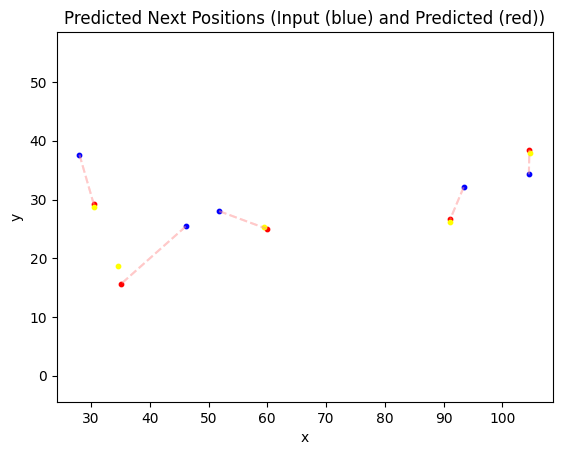

In [140]:
sample = plot_df.sample(5)

for _, row in sample.iterrows():
    plt.plot([row["x_input"], row["x_pred"]], [row["y_input"], row["y_pred"]],
             'r--', alpha=0.3)
    plt.plot([row["x_input"], row["x_pred"]], [row["y_input"], row["y_pred"]],
             'w--', alpha=0.3)  # model step
    plt.scatter(row["x_input"], row["y_input"], color='blue', s=10)
    plt.scatter(row["x_pred"], row["y_pred"], color='red', s=10)
    plt.scatter(row["x_true"], row["y_true"], color='yellow', s=10)

plt.title("Predicted Next Positions (Input (blue) and Predicted (red))")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

